# Windowing sensitivity

The goal of this notebook is to illustrate and study the sensitivity of the results based on the windowing sizes. It will hopefully allow for some insight towards what values we can use

## Setting up environment + loading data

In [91]:
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    19:59:49 	 ApRESDefs.py @function _setup_logging line 494 - Stream logging level set to DEBUG
DEBUG    19:59:49 	 ApRESDefs.py @function _setup_logging line 495 - Add console handler to logger
DEBUG    19:59:49 	 ApRESDefs.py @function _setup_logging line 508 - File logging level set to DEBUG


In [2]:
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42061")
client

Connection method: Direct,
Dashboard: /user/glugeorge/proxy/8787/status,
Comm: tcp://127.0.0.1:42061,Workers: 0
Dashboard: /user/glugeorge/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Let's load in stacked data from every 6 hours from the month of July. We use the first attenuator setting and ignore the first chirp. We than stack the chirps  

In [5]:
date_range = xr.date_range('2022-07-01T12:00:00.000000000','2022-08-01T12:00:00.000000000',freq='6H')
profiles_6h = ds_101.isel(attenuator_setting_pair=1,chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='6H').mean(dim='time').sel(time=date_range).compute()
profiles_6h

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


<xarray.DataArray 'profile' (time: 125, profile_range: 6658)>
array([[ 1.07435713e-02,  4.21849129e-06, -6.39879536e-03, ...,
         1.85761274e-06,  2.00137121e-06, -1.76728445e-06],
       [ 1.07312231e-02,  4.19718247e-06, -6.39128072e-03, ...,
         1.71970567e-06,  2.02020397e-06, -1.40183975e-06],
       [ 1.08065368e-02,  3.24051577e-06, -6.43433379e-03, ...,
         4.18513473e-07,  1.52907789e-06, -4.38037423e-07],
       ...,
       [ 1.08874140e-02, -2.09176841e-05, -6.44612806e-03, ...,
        -1.25446239e-06, -1.05190834e-06, -5.09822545e-07],
       [ 1.08869808e-02, -2.13011593e-06, -6.47430417e-03, ...,
         1.65418612e-06,  2.27548710e-06, -2.82638398e-06],
       [ 1.07378965e-02,  3.47868141e-05, -6.42841903e-03, ...,
        -3.84329877e-07, -3.52023298e-07, -5.09059313e-07]])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-07-01T12:00:00 ... 2022-08-01T1...
    attenuator     float64 5.0
    AFGain         int64 -14

## Looking through the 6 hour data

In [8]:
vels_total = []
stagger = 1
for i in range(0,len(profiles_6h.time)-stagger):
    s1 = profiles_6h.isel(time = i)
    s2 = profiles_6h.isel(time = i+stagger)
    vels = xa.generate_range_diff(s1,s2,30,30)
    vels_total.append(vels)
vels_array = xr.concat(vels_total,dim='time') 

INFO     15:57:56 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     15:57:57 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     15:57:58 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     15:58:00 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     15:58:01 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     15:58:02 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     15:58:03 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     15:58:04 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     15:58:05 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     15:58:06 	 ApRESDefs.py @function generate_ran

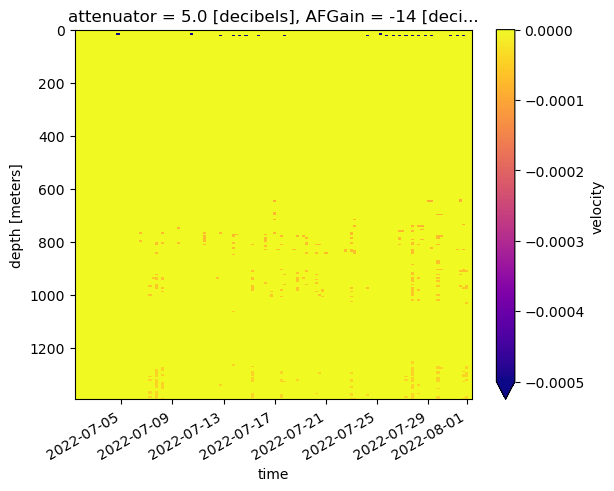

In [13]:
vels_array.velocity.plot(x='time',cmap='plasma',vmin=-0.0005)
plt.gca().invert_yaxis()

Now defining a pair of 6h stacks at the start of July and a pair at the end. We will use this to examine the consistency of these calculations

In [16]:
s1 = profiles_6h.isel(time = 1)
s2 = profiles_6h.isel(time = 2)
s3 = profiles_6h.isel(time = len(profiles_6h.time)-2)
s4 = profiles_6h.isel(time = len(profiles_6h.time)-1)

## Testing correlation window + step

First, let's look at the velocities between consecutive bursts. Remember the velocity function looks like: `generate_range_diff(self, data1, data2, win_cor, step, range_ext=None, win_wrap=10, thresh=0.9, uncertainty='CR')`. 

From [IMPDAR's scripts](https://github.com/dlilien/ImpDAR/blob/main/impdar/tests/test_TimeDiffProcessing.py), it looks like the step and the correlation window should be the same. We'll keep with this and try out different values.

INFO     18:23:28 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:23:31 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:23:35 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:23:38 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:23:41 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:23:42 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:23:43 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:23:44 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:23:44 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:23:45 	 ApRESDefs.py @function gene

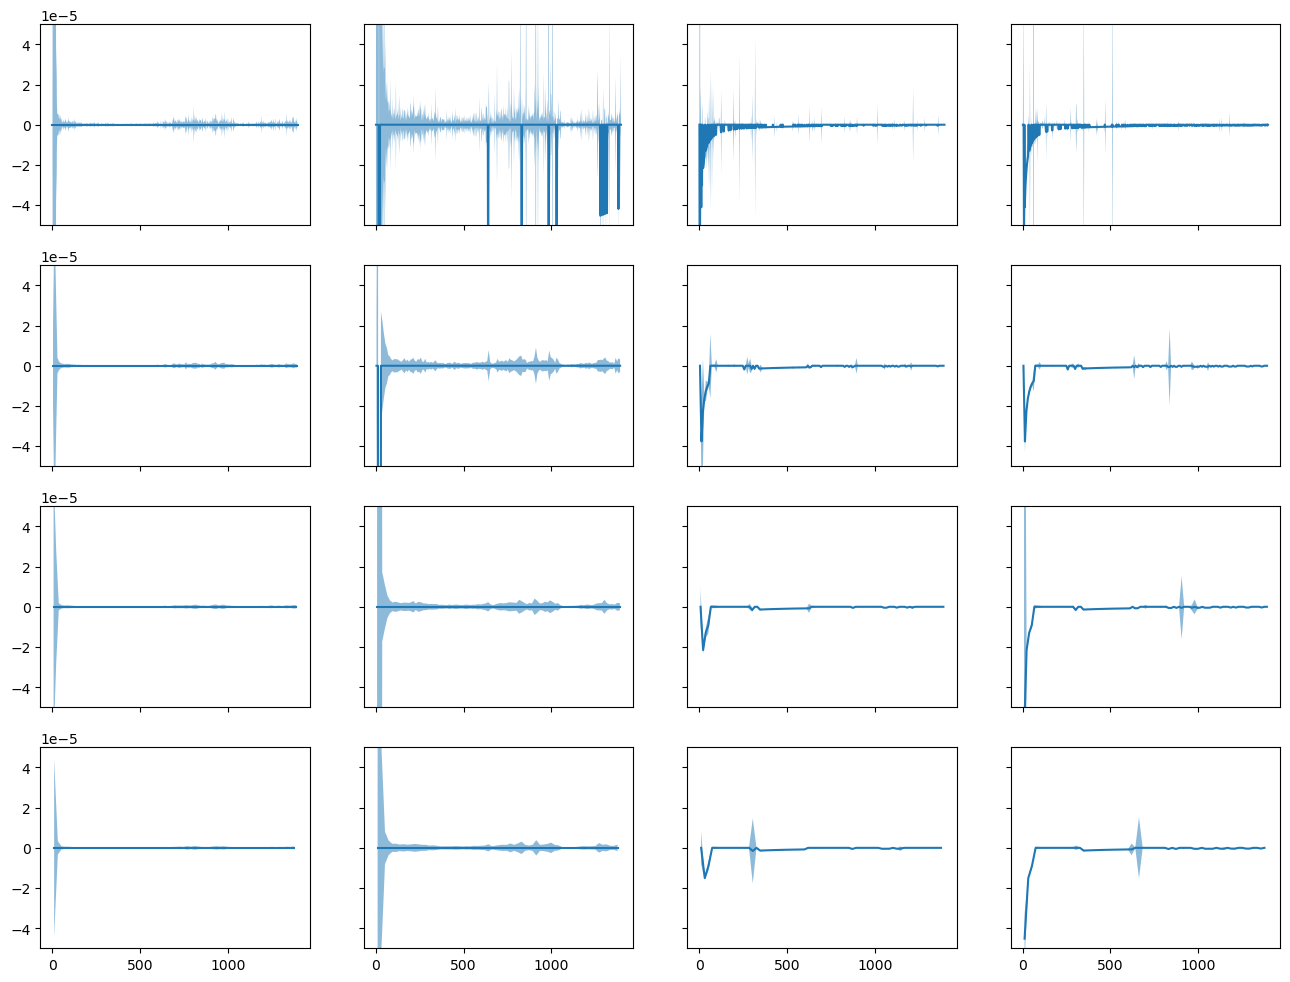

In [36]:
fig = plt.figure(figsize=(16, 12))
axes = fig.subplots(nrows=4, ncols=4,sharex=True,sharey=True)
sizes = [10,40,70,100]
combos = [[s1,s2],[s3,s4],[s1,s3],[s2,s4]]
for i in range(0,4):
    for j in range(0,4):
        vels = xa.generate_range_diff(combos[j][0],combos[j][1],sizes[i],sizes[i])
        axes[i][j].plot(vels.profile_range,vels.velocity)
        axes[i][j].fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)
        axes[i][j].set_ylim(-5e-5,5e-5)

Changing the wrapping window size:

INFO     18:34:57 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:34:58 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:34:59 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:35:00 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:35:01 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:35:02 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:35:03 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:35:04 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:35:05 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:35:07 	 ApRESDefs.py @function gene

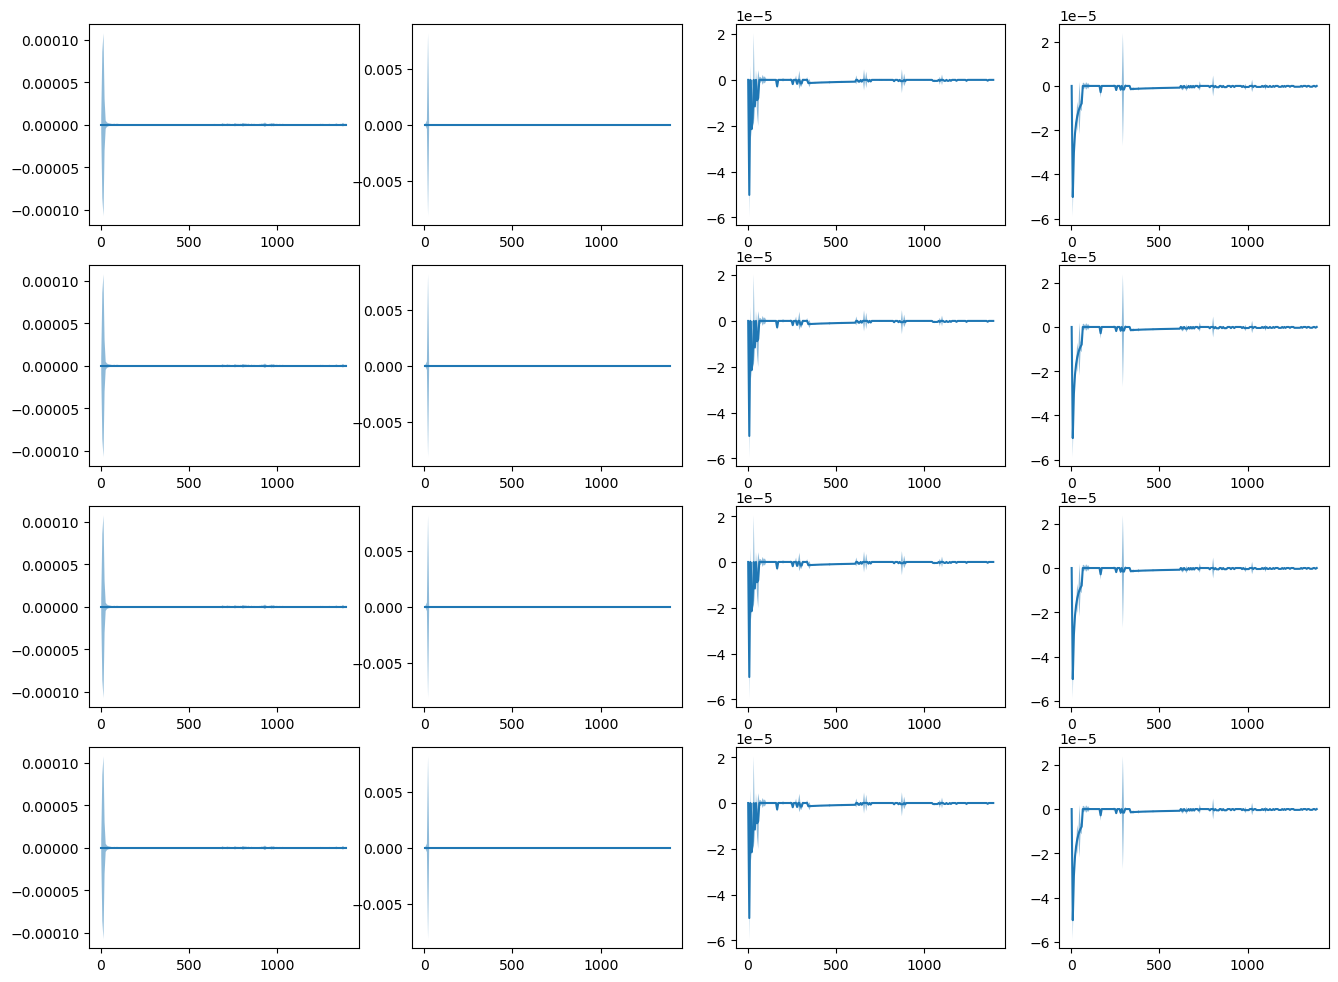

In [37]:
fig = plt.figure(figsize=(16, 12))
axes = fig.subplots(nrows=4, ncols=4)
sizes = [5,30,55,80]
combos = [[s1,s2],[s3,s4],[s1,s3],[s2,s4]]
for i in range(0,4):
    for j in range(0,4):
        vels = xa.generate_range_diff(combos[j][0],combos[j][1],30,30,None,sizes[i])
        axes[i][j].plot(vels.profile_range,vels.velocity)
        axes[i][j].fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

INFO     18:36:29 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:36:30 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:36:31 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:36:33 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:36:34 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:36:35 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:36:36 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:36:37 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2635200.0s
INFO     18:36:38 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 21600.0s
INFO     18:36:39 	 ApRESDefs.py @function gene

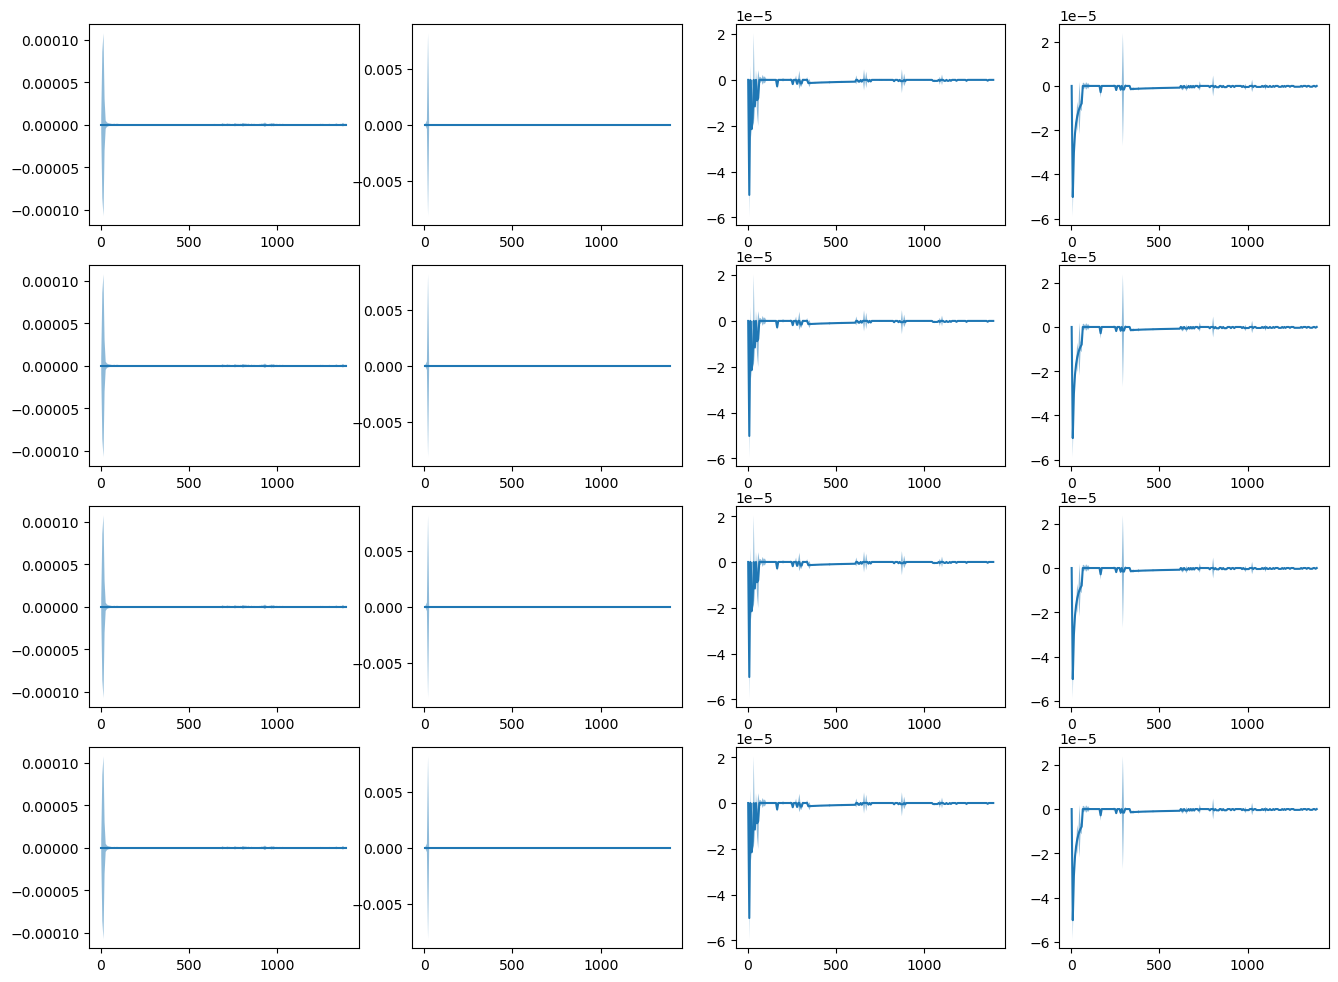

In [38]:
fig = plt.figure(figsize=(16, 12))
axes = fig.subplots(nrows=4, ncols=4)
sizes = [0.4,0.6,0.8,0.99]
combos = [[s1,s2],[s3,s4],[s1,s3],[s2,s4]]
for i in range(0,4):
    for j in range(0,4):
        vels = xa.generate_range_diff(combos[j][0],combos[j][1],30,30,None,10,sizes[i])
        axes[i][j].plot(vels.profile_range,vels.velocity)
        axes[i][j].fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

From these rudimentary plots above, it seems like the main influence on results is the correlation window + step values, while the wrapping window and threshold don;t have much an effect.

## Extra more disorgaized experiments

In [51]:
date_range = xr.date_range('2022-07-01T12:00:00.000000000','2022-08-01T12:00:00.000000000',freq='1D')
profiles_1D = ds_101.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1D').mean(dim='time').sel(time=date_range,method='nearest').compute()
profiles_1D

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


<xarray.DataArray 'profile' (time: 32, profile_range: 6658,
                             attenuator_setting_pair: 2)>
array([[[ 1.04232877e-02,  1.07537489e-02],
        [ 1.34649428e-05,  3.52301476e-06],
        [-6.21276056e-03, -6.40351489e-03],
        ...,
        [ 4.16218013e-06,  1.12947598e-06],
        [ 5.57123616e-06,  1.45731444e-06],
        [-4.05406073e-06, -1.06825813e-06]],

       [[ 1.04306212e-02,  1.07699429e-02],
        [ 2.24777417e-05,  4.49532767e-06],
        [-6.22970063e-03, -6.41487505e-03],
        ...,
        [ 7.88771822e-06,  2.20681014e-06],
        [ 5.80383437e-06,  1.56425432e-06],
        [-6.71663895e-06, -1.85085658e-06]],

       [[ 1.04140725e-02,  1.07657704e-02],
        [ 3.08997760e-05,  2.95806339e-06],
        [-6.22623632e-03, -6.41118371e-03],
        ...,
...
        ...,
        [-8.76682533e-07, -5.18512544e-07],
        [ 4.50818150e-06,  1.67736242e-06],
        [-3.15780233e-06, -9.33510964e-07]],

       [[ 1.03949468e-02,  1.08008314e-02],
        [ 6.69306922e-05,  8.09801099e-06],
        [-6.23199761e-03, -6.43317762e-03],
        ...,
        [ 1.51269669e-06,  3.41108492e-07],
        [ 2.72580983e-06,  4.17197180e-07],
        [-4.48509831e-06, -1.47202663e-06]],

       [[ 1.03685965e-02,  1.07810666e-02],
        [ 6.27383512e-05,  1.12764207e-05],
        [-6.19332411e-03, -6.42296561e-03],
        ...,
        [-3.76916972e-06, -1.32010414e-06],
        [-9.92906722e-07, -1.00696760e-06],
        [ 1.11349164e-06,  7.49163830e-07]]])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-07-02 2022-07-03 ... 2022-08-02
    attenuator     (attenuator_setting_pair) float64 5.0 5.0
    AFGain         (attenuator_setting_pair) int64 -4 -14
Dimensions without coordinates: attenuator_setting_pair

In [108]:
w0 = profiles_1D.isel(time = 0)
w4 = profiles_1D.isel(time = 31)


INFO     21:04:49 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2678400.0s
INFO     21:04:53 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2678400.0s
INFO     21:04:57 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2678400.0s
INFO     21:04:58 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2678400.0s
INFO     21:04:59 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2678400.0s
INFO     21:04:59 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2678400.0s
INFO     21:05:00 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2678400.0s
INFO     21:05:00 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 2678400.0s


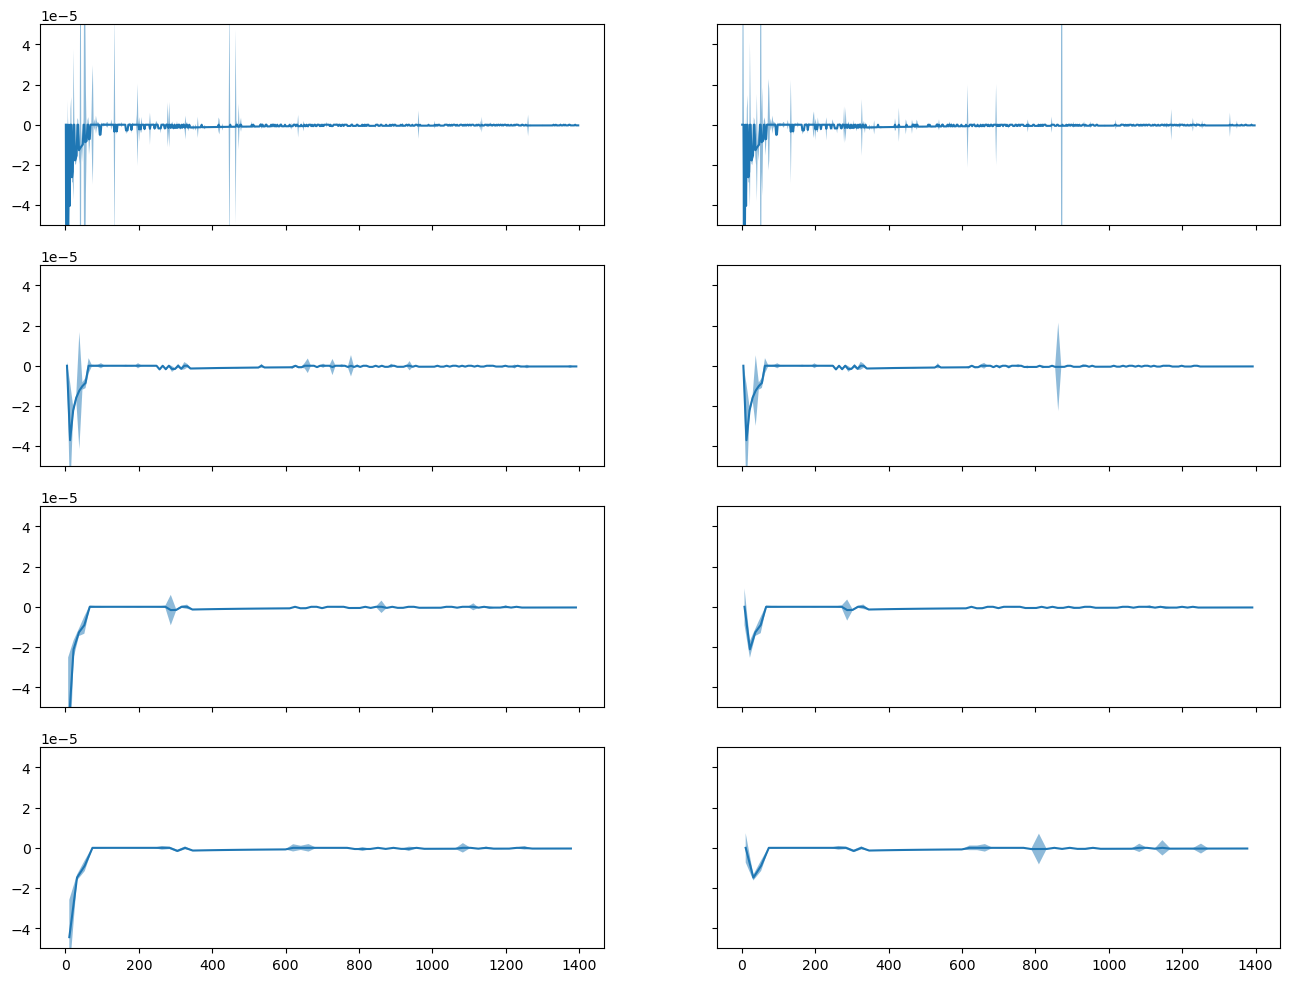

In [109]:
fig = plt.figure(figsize=(16, 12))
axes = fig.subplots(nrows=4, ncols=2,sharex=True,sharey=True)
sizes = [10,40,70,100]
for i in range(0,4):
    for j in range(0,2):
        vels = xa.generate_range_diff(w0.isel(attenuator_setting_pair=j),w4.isel(attenuator_setting_pair=j),sizes[i],sizes[i])
        axes[i][j].plot(vels.profile_range,vels.velocity)
        axes[i][j].fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)
        axes[i][j].set_ylim(-5e-5,5e-5)

In [92]:
vels_total = []
stagger = 1
for i in range(0,len(profiles_1D.time)-stagger):
    s1 = profiles_1D.isel(time = 0, attenuator_setting_pair=0)
    s2 = profiles_1D.isel(time = i+stagger,attenuator_setting_pair=0)
    vels = xa.generate_range_diff(s1,s2,50,50)
    vels_total.append(vels)
vels_array = xr.concat(vels_total,dim='time') 

INFO     19:59:55 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     19:59:55 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 172800.0s
INFO     19:59:56 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 259200.0s
INFO     19:59:57 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 345600.0s
INFO     19:59:58 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 432000.0s
INFO     19:59:58 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 518400.0s
INFO     19:59:59 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 604800.0s
INFO     20:00:00 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 691200.0s
INFO     20:00:01 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 777600.0s
INFO     20:00:01 	 ApRESDefs.py @function gene

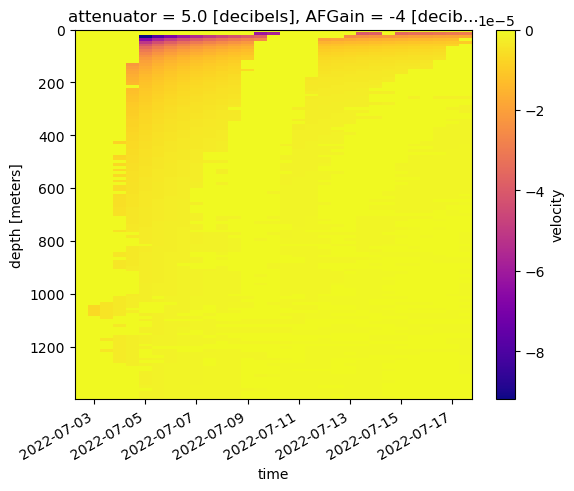

In [93]:
vels_array.velocity.plot(x='time',cmap='plasma')
plt.gca().invert_yaxis()

In [94]:
vels_array

<xarray.Dataset>
Dimensions:        (profile_range: 133, time: 31)
Coordinates:
  * profile_range  (profile_range) float64 5.257 15.77 ... 1.383e+03 1.393e+03
  * time           (time) datetime64[ns] 2022-07-02T12:00:00 ... 2022-07-17T1...
    attenuator     float64 5.0
    AFGain         int64 -4
Data variables:
    velocity       (time, profile_range) float64 -0.0 -0.0 ... -3.356e-07
    uncertainty    (time, profile_range) float64 -1.134e-05 ... -2.072e-08

In [107]:
ds_101


<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11723,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) float64 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>